# Homework 1

### CS328 — Numerical Methods for Visual Computing and Machine Learning
- - -

**Out** on Thursday 30/09/2021, **due** on Thursday 14/10/2021.

This notebook contains literate code, i.e. brief fragments of Python surrounded by descriptive text. Please complete/extend this notebook for your homework submission:

* Begin your response to each problem with a <tt>&nbsp;<b>## Solution</b>&nbsp;&nbsp;</tt> markdown cell.
* In addition to your code, please **also provide a short description of what your solution is doing and how it works**, either by adding comments or in an extra markdown cell.
* Before handing in, please make sure that your notebook runs from top to bottom after selecting "Kernel->Restart & Run All" without causing any errors. To simplify the grading process, please do **not** clear the generated output.

Make sure to use the reference Python distribution so that project files can be opened by the TAs. In this course, we use <a href="https://www.anaconda.com/products/individual">Anaconda</a>, specifically the version based on Python 3.8.

<div class="alert alert-warning">
Homework assignments in CS328 count towards your final grade and must therefore be done individually.
</div>

### Prelude

The following fragment imports NumPy and Matplotlib and configures the latter to produce nice graphics on modern high-resolution screens. The import statements at the end establish a shorthand notation for the most common integer and floating point formats.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import numpy as np
from matplotlib import pyplot as plt

from numpy import uint16  as u16
from numpy import uint32  as u32
from numpy import uint64  as u64
from numpy import float16 as f16
from numpy import float32 as f32
from numpy import float64 as f64

Two more definitions: the helper functions ``f2i`` and ``i2f``  below reinterpret floating point values as an integers and vice versa. We'll use these in Problem 3 to access the bit-level representation of an IEEE 754 floating point value.

In [2]:
def f2i(value):
    ''' Reinterpret floating point value as integer '''
    return value.view('u%i' % value.itemsize)

def i2f(value):
    ''' Reinterpret integer as floating point value '''
    return value.view('f%i' % value.itemsize)

## Problem 1: Images, slicing, and color balancing (15 pts)

The following two lines of code download a portrait photograph from the Wikipedia article on [color balance](https://en.wikipedia.org/wiki/Color_balance) and store it in a single precision NumPy array named ``image``, whose pixels are in the range ``[0.0, 1.0]``.

In [3]:
import PIL, requests
image = np.array(PIL.Image.open(requests.get('https://goo.gl/VcYNGN', stream=True, headers = {'User-agent': 'Mozilla/5.0'}).raw), dtype = np.float32) / 255

Try plotting this image using ``plt.imshow``.

## Solution

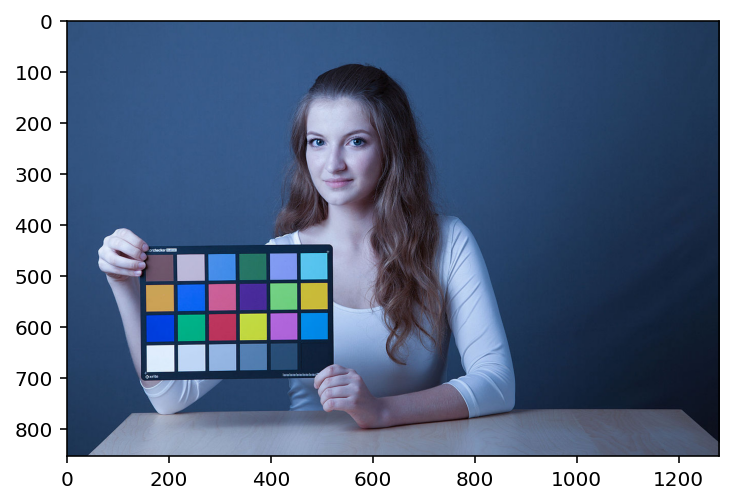

In [4]:
plt.imshow(image)

You will notice that the colors are distorted by a strong blue tint. Such intense color casts can lead to unnatural appearance and are usually not desired in portrait photography. In such cases, *color balancing* can be used to post-process the colors of an existing image to e.g. ensure that white objects indeed appear white in the image. One of the simplest kinds of color balancing is known as *white balancing*. Here, we select a region of the image that is known to contain a neutral color, and we then determine the reciprocal of the associated red, green, and blue color values. Afterwards, the color channels of the entire image are scaled by these reciprocals, ensuring that the selected region becomes neutral (i.e. it has similar amounts of red, green, and blue).

Note that the woman holds a [color checker](https://en.wikipedia.org/wiki/ColorChecker) in her hands. A color checker consists of an arrangement of colored patches with known color values, and the last row usually contains neutral colors. We will  use the second neutral patch on the bottom left to white-balance this image.

**TODO**: Use NumPy *slicing* operations to crop out the second neutral patch in the last row (counting from the left side) and plot it using ``plt.imshow``. The cropped region should be as large as possible without including the black frame or other patches.

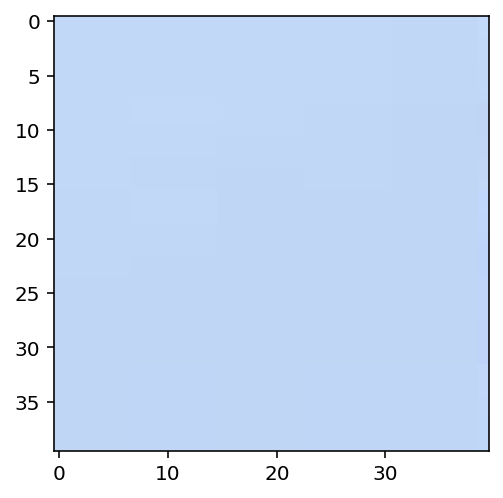

In [5]:
second_neutral_patch = image[640:680, 225:265]
plt.imshow(second_neutral_patch)

**TODO**: Compute the mean of the R, G, and B color channels over the patch. You should be able to accomplish this with a single function call to ``np.mean``. Print the computed mean using ``print()``.

In [6]:
mean_channels = np.mean(second_neutral_patch, axis = (0, 1))

print('Mean of the R (red) color channel:', mean_channels[0])
print('Mean of the G (green) color channel:', mean_channels[1])
print('Mean of the B (blue) color channel:', mean_channels[2])

Mean of the R (red) color channel: 0.7517731
Mean of the G (green) color channel: 0.8418245
Mean of the B (blue) color channel: 0.9642178


**TODO**: Now, use *broadcasting* to multiply the image R, G, B channels by the reciprocals (inverses) of the values computed above and visualize the result using ``plt.imshow``. *Note*: You may need to scale the image by a small amount to prevent pixels overflowing to a value greater than ``1.0``, which will lead to strange color artifacts. (Our reference implementation uses a value of ``0.85``.)

<div class="alert alert-block alert-info">
Value 0.85 causes pixels overflowing to a value greater than 1.0, therefore, I use 0.75 instead
</div>

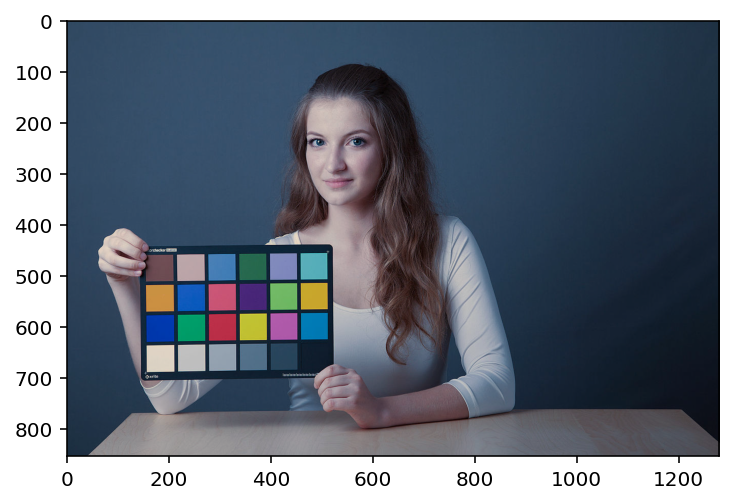

In [7]:
image_broadcast = image * (1 / mean_channels) * 0.75
plt.imshow(image_broadcast)

# Problem 2: Triple Birthday Paradox (25 pts)

Let us again consider the [Birthday Paradox](https://en.wikipedia.org/wiki/Birthday_problem) that was introduced during the first week's exercise session. In this task, we will study a slightly modified problem that can be summarized with the following question:

**What is the probability that at least *three* people in a random set of $n$ people share the same birthday?**

In the following, you will develop a simple numerical Python program to solve this problem and then make use of vectorization with NumPy arrays to speed it up. For this reason, you should use the "magic" Jupyter function ```%%time``` to profile the execution time of your implementation at every step.

## Problem 2.1: Basic Python Implementation (10 pts)

**TODO**: Write a basic Python program<a name="myfootnote1"><sup>[1]</sup></a> that estimates of the "3-birthdays probability" based on random sampling. 

Feel free to reuse code from the [first weeks notebook](https://moodle.epfl.ch/mod/resource/view.php?id=1084885) to get some inspiration on how you would do this.
The structure should stay exactly the same:
1. Choose $n$ random birthdays (i.e. integers)
2. Check if *three* of the birthdays are the same
3. Repeat this process $K$ times and keep track of how many times it was true
4. Return the ratio between "number successful events" and "total number events" ($K$)

When you chose $K$ large enough, a simulation like this should give you a good estimate of the true probability.

Remember that you can generate random integers by using *```randint```* from the *```random```* module:

```python
import random as rnd
a = rnd.randint(0, 10) # Random integer between 0 and 10 (including)
```
[[1]](#myfootnote1) Do **not** use any of the NumPy, SciPy, ... libraries in this part of the exercise—only pure Python is allowed.

## Solution

<div class="alert alert-block alert-info">
Inside "for it in range(K)" the function generates a random sequance of numbers from $0$ to $365$ (inclusive) as a representation of $n$ random birthdays, creates a list of values that occur in the sequence $3$ or more times, and checks if the list is non-empty. If so, counts this as a successful event.
</div>

In [8]:
import random as rnd

In [9]:
# For n people, compute an approximation of the probability that at
# least three people share the same birthday, using K iterations
def birthday_paradox_basic(n, K):
    counter = 0 # Keep track of how often the statement is true
    
    # Perform K iterations of the same experiment.
    for it in range(K):
        
        dates = [rnd.randint(0, 365) for i in range(n)]
        success = len([x for x in dates if dates.count(x) > 2]) > 0
        
        if success:
            counter += 1  
    
    # Return average probability
    return counter / K

To test if your program is operating correctly, try running it for $n=88$ people using a very high value of $K$ (e.g. ``100000``). This should give you (in expectation) a probability slightly above $0.5$:

In [10]:
birthday_paradox_basic(88, 100000)

0.51084

**TODO**: Finally, profile the running time of the implementation and report how much time it took for $K=100000$. You can do this simply by putting the ["magic command"](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-time) ``%%time`` at the top of the cell that should be timed:

In [11]:
%%time
birthday_paradox_basic(88, 100000)

CPU times: user 14.9 s, sys: 32.8 ms, total: 14.9 s
Wall time: 14.9 s


0.50931

* It runs in 15 seconds

## Problem 2.2: Vectorized implementation using NumPy (15 pts)

As you likely noticed, an implementation in pure Python is rather slow! As a frame of reference: an implementation with list comprehensions (as was done during the exercise session) can easily take half a minute to complete for large values of $K$ like above. Creating lists of random integers is a particularly slow operation that can be considerably accelerated using vectorized NumPy functions that process entire NumPy arrays at a once.

**TODO**: Write another function that computes the same result, but this time, replace the inner part of the "*```for it in range(K)```*" loop with a combination of NumPy array functions.<a name="myfootnote2"><sup>[2]</sup></a>

Here are a number of NumPy functions that you may find helpful:
* ```np.random.randint```
* ```np.bincount```
* ```np.unique```
* ```np.min, np.max```
* ```np.arange```
* ```np.any```

You can read about these in the [NumPy Documentation](https://numpy.org/doc/stable/).

**Hint**: The output range of ```np.random.randint``` differs slightly from ```random.randint``` provided by the standard library that you used above. Make sure not to introduce any subtle off-by-one errors!

[[2]](#myfootnote2) In this part of the exercise, do **not** use Python lists and list comprehensions, and do not explicitly iterate over the days of the year. Do **not** use ```np.vectorize```, ```np.apply_along_axis``` (or similar constructs) that merely emulate vectorization using a slow Python ``for`` loop internally.

## Solution

<div class="alert alert-block alert-info">
Inside "for it in range(K)" the function generates a random sequence of numbers from $0$ to $366$ (exclusive), counts the number of occurrences using np.bincount and checks the presence of occurrences which amount is greater than 2. If so, counts this as a successful event.
</div>

In [12]:
# For n people, compute an approximation of the probability that at
# least three people share the same birthday, using K iterations
def birthday_paradox_numpy(n, K):
    counter = 0 # Keep track of how often the statement is true
    
    # Perform K iterations of the same experiment.
    for it in range(K):
        
        dates = np.random.randint(0, 366, size = n)
        success = np.any(np.bincount(dates) > 2)
        
        if success:
            counter += 1  
    
    # Return average probability
    return counter / K

**TODO**: Profile the running time of the implementation vectorized implementation for $K=100000$ like above and report the (approximate) speedup in a markdown cell or comment.

In [13]:
%%time
birthday_paradox_numpy(88, 100000)

CPU times: user 1.24 s, sys: 7.22 ms, total: 1.25 s
Wall time: 1.25 s


0.50915

* The `birthday_paradox_basic` runs in 15 s, `birthday_paradox_numpy` runs in 1.23 s, the speedup is equal to 13.77 s

## Problem 2.3: Optional Exercise (0 points, not graded)
-- --
<br/>Although the vectorized implementation is a tremendous improvement, it still contains a loop over a potentially large number of virtual experiments. We can do better!

* Implement a version that fully relies on vectorized NumPy functions and contains no more loops. As above, do **not** use ```np.vectorize```, ```np.apply_along_axis``` (or similar constructs) that merely emulate vectorization using a slow Python ``for`` loop internally.
* Again, profile your code and report the speedup compared to both the "pure Python" and previous NumPy implementation. We expect to see at least some additional speedup here. (As a frame of reference, our solution to this problem achieves `~4x` speedup compared to problem 2.2.)



## Problem 3: Measuring error using ULPs (25 pts)
-- --

A special property of the IEEE754 floating point specification is that contiguous ranges of floating point numbers are also contiguous when re-interpreted as unsigned integers, e.g. by after applying the function ``f2i`` defined above. See the next figure for an illustration of this.

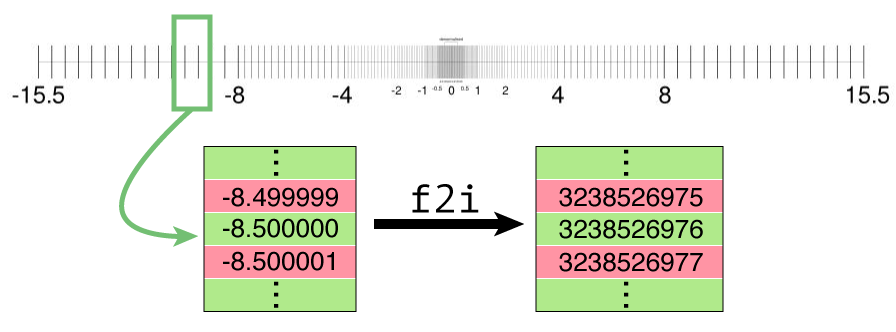

Use this property along with the functions ``f2i`` and ``i2f`` and the aliases ``f16`` etc. defined above to answer the following questions:

1. How many floating point values are located between the values ``1`` and ``2``, including the endpoints? How about ``1001`` and ``1002`` ? Give answers for 16, 32, and 64 bit precision variants. <br><br>

2. How large is 1 ULP for the value $\pi$ expressed in 64 bit arithmetic? Remember that one ULP was defined as the jump that occurred when changing the last mantissa bit from a ``1`` to a ``0`` (or vice versa).<br><br>

3. Suppose that we compute the surface area of the earth from its radius of $\approx 6.353\cdot 10^6m$ using the expression $A=4\pi r^2$. Assuming that the earth is perfectly spherical, and that the discretization of $\pi$ is the only source of error in this computation, bound the absolute error in square meters.

## Solution

* *Answer to the 1st question:*

<div class="alert alert-block alert-info">
In order to count the number of floating point values between two numbers for a particular precision variant, I take the two numbers using this precision variant, reinterpret floating point values as integers using f2i function, and then subtract received integers adding 1 (to include the endpoints).
</div>

In [14]:
f2i_1_f16 = f2i(f16(1))
f2i_2_f16 = f2i(f16(2))
print(f'There are {f2i_2_f16 - f2i_1_f16 + 1} floating point values between 1 and 2 in f16')

f2i_1_f32 = f2i(f32(1))
f2i_2_f32 = f2i(f32(2))
print(f'There are {f2i_2_f32 - f2i_1_f32 + 1} floating point values between 1 and 2 in f32')

f2i_1_f64 = f2i(f64(1))
f2i_2_f64 = f2i(f64(2))
print(f'There are {u64(f2i_2_f64 - f2i_1_f64 + 1)} floating point values between 1 and 2 in f64')

There are 1025 floating point values between 1 and 2 in f16
There are 8388609 floating point values between 1 and 2 in f32
There are 4503599627370497 floating point values between 1 and 2 in f64


In [15]:
f2i_1001_f16 = f2i(f16(1001))
f2i_1002_f16 = f2i(f16(1002))
print(f'There are {f2i_1002_f16 - f2i_1001_f16 + 1} floating point values between 1001 and 1002 in f16')

f2i_1001_f32 = f2i(f32(1001))
f2i_1002_f32 = f2i(f32(1002))
print(f'There are {f2i_1002_f32 - f2i_1001_f32 + 1} floating point values between 1001 and 1002 in f32')

f2i_1001_f64 = f2i(f64(1001))
f2i_1002_f64 = f2i(f64(1002))
print(f'There are {u64(f2i_1002_f64 - f2i_1001_f64 + 1)} floating point values between 1001 and 1002 in f64')

There are 3 floating point values between 1001 and 1002 in f16
There are 16385 floating point values between 1001 and 1002 in f32
There are 8796093022209 floating point values between 1001 and 1002 in f64


* *Answer to the 2nd question:*

<div class="alert alert-block alert-info">
In order to get a ULP for $\pi$ in 64 bit arithmetic, I take $\pi$ using the 64 bit precision variant, reinterpret the floating point value as an integer using f2i function, get the next value by adding 1 to the received integer, reinterpret this integer as a floating point value using i2f function and subtract floating point value of $\pi$ from the next floating point value.
</div>

In [16]:
pi_f64 = f64(np.pi)
f2i_pi_f64 = f2i(pi_f64)
f2i_pi_next_f64 = f2i_pi_f64 + u64(1)
pi_next_f64 = i2f(f2i_pi_next_f64)
ULP = pi_next_f64 - pi_f64

print('ULP for value pi expressed in 64 bit arithmetic is equal to', ULP)

ULP for value pi expressed in 64 bit arithmetic is equal to 4.440892098500626e-16


* *Answer to the 3rd question:*

<div class="alert alert-block alert-info">
Since the discretization of $\pi$ is the only source of error in this computation, we have:
</div>

In [17]:
abs_err = 4 * ULP * f64((6.353 * 10 ** 6) ** 2)
print('The absolute error in square meters is bounded by the value', abs_err)

The absolute error in square meters is bounded by the value 0.0716948438395093


## Problem 4: Series approximations (25 pts)
-- --

In Lecture 1, we saw how various numerical issues could occur due to the floating point number representation.  
Consider the power series representation of the sine function:

$$
\sin(x)=x-\frac{x^3}{3!}+\frac{x^5}{5!}-\frac{x^7}{7!}+\cdots
$$

**Hint**: the first 20 coefficients of the sine power series representation look like this:

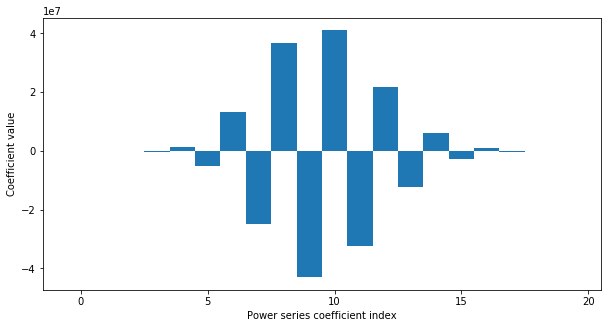

1. Evaluate the power series at \(x=20\) using the first 100 terms and compute the absolute and relative error (you can assume that ``np.sin`` is accurate). *Hint*: the factorial function is provided in ``scipy.special``.<br><br>

2. Express the error as an integer number of ULPs (see also Problem 3) -- in other words, how many floating point numbers are between the true and the approximate answer?<br><br>

3. Now, evaluate the exponential function at ``x=30`` using the same approach: using its corresponding power series, and assuming that ``np.exp`` is accurate. Specify the absolute and relative error. What do you observe compared to the sine power series? Why is this the case?<br><br>

4. List three different kinds of numerical problems that can arise when evaluating the above two power series with very many terms (e.g. thousands), and what parts of the expression specifically cause them.

## Solution

* *Answer to the 1st question:*

In [18]:
from scipy.special import factorial

In [19]:
# Approximate sin function using the first n terms of the power series at x
def sin_approx(x = 20, n = 100):
    terms_sum = 0 # Accumulating the power series terms
    
    for i in range(n):
        terms_sum += (-1) ** i * x ** (2*i + 1) / factorial(2*i + 1)
    
    # Return the sum of the first n terms
    return terms_sum

In [20]:
abs_err = abs(np.sin(20) - sin_approx())
print('The absolute error of the power series evaluation for SIN is equal to', abs_err)

rel_err = abs_err / np.sin(20)
print('The relative error of the power series evaluation for SIN is equal to', rel_err)

The absolute error of the power series evaluation for SIN is equal to 5.546900161412793e-09
The relative error of the power series evaluation for SIN is equal to 6.075830020466015e-09


* *Answer to the 2nd question:*

<div class="alert alert-block alert-info">
In order to express the error as an integer number of ULPs, I count the number of floating point values between the true and the approximate answer by the following way: I reinterpret floating point values as integers using f2i function, subtract received integers and then subtract 1 (to exclude endpoints).
</div>

In [21]:
f2i_sin20 = f2i(np.sin(20))
f2i_sin_approx = f2i(sin_approx())
print(f'There are {u64(f2i_sin_approx - f2i_sin20 - 1)} floating point values between the true and the approximate answer')

There are 49962034 floating point values between the true and the approximate answer


* *Answer to the 3rd question:*

In [24]:
# Approximate exp function using the first n terms of the power series at x
def exp_approx(x = 30, n = 100):
    terms_sum = 0.0 # Accumulating the power series terms
    
    for i in range(n):
        terms_sum += x ** i / factorial(i)
        
    # Return the sum of the first n terms
    return terms_sum

In [25]:
abs_err = abs(np.exp(30) - exp_approx())
print('The absolute error of the power series evaluation for EXP is equal to', abs_err)

rel_err = abs_err / np.exp(30)
print('The relative error of the power series evaluation for EXP is equal to', rel_err)

The absolute error of the power series evaluation for EXP is equal to 3.906250e-03
The relative error of the power series evaluation for EXP is equal to 3.655321472203193e-16


<div class="alert alert-block alert-info">
The observation consists in that the absolute error for the sine power series is $\sim 10^6$ lower than for the exponential power series, but the relative error for the sine power series is $\sim 10^7$ higher than for the exponential power series. 
    
This behavior can be justified by the fact that the sine values flucturate between $[-1, 1]$, whereas $exp(x)$ is monotonically increasing function that has a large value at $x = 30$.
</div>

* *Answer to the 4th question:*

<div class="alert alert-block alert-info">
Numerical problems that can arise when evaluating the two abovementioned power series with many terms:<br><br>
1. Rounding or truncation error: comes from rounding and other approximations used to deal with the fact that we can only represent a finite set of values. As the power progresses, the current sum $s$ will become large relative to the next additional term, so that the following summands $x_i$ will change only the lowest-order bits of $s$ and in the extreme case $s$ will be large enough that adding $x_i$ will have no effect whatsoever. Furthermore, the next power term $x_i$ can become so small that its value will be truncated to zero due to the precision limits.<br><br>
2. Discretization error: this error comes from our computerized adaptation of calculus, since we take only finite quantity of summands from the power series that by definition is a sum of infinite number of terms.<br><br>
3. Modeling error: for the approximation we take the power series at $x=0$, hence outside the infinitesimal locality of zero its value will be less precise. Therefore, we would get better results if we computed the approximation using the power series at $x=20$ and $x=30$ respectively.
</div>